# 15 minutes to QCoDeS

This short introduction is aimed mainly for beginner's. Before you can start with your first code using QCoDeS make sure you have properly set up the environment for QCoDeS (look at [this  documentation](http://qcodes.github.io/Qcodes/start/index.html#installation)). 

## Introduction 

An experimental setup comprises of many instruments. We call an experimental setup as "station". A station is connected to many instruments or devices. QcoDeS provides a way to interact with all these instruments to help users perform the measurements and store the data in a database. To  interact (read/ write/ trigger etc) with individual instruments we have created a [library of drivers](http://qcodes.github.io/Qcodes/api/generated/qcodes.instrument_drivers.html) for commonly used instruments. These drivers implement the commonly needed functionalities of the instruments. 

An "Instrument" can perform many functions. For example, on an oscilloscope instrument we first set a correct trigger level and then obtain a trace. In QCoDeS lingo, we call "trigger_level" and "trace" as parameters of this `instrument`. An instrument at any moment will have many such parameters which together defines the state of the instrument, hence a parameter can be thought of as a state variable of the instrument. QCoDeS provides method to set values of this parameter (set trigger level) and get the values form them (obtain a trace). This way we can interact with all the needed parameters of an instrument and are ready to set up a measurement. 

QCoDeS also have a similar programmatic structure as explained above. QCoDeS structure comprise of a `Station` class which is bucket of objects from `Instrument` class containing many `Parameters`. The value of these parameters are set and measured during a `Measurement`. The `Measurement` class provides context manager for registering the parameters and providing link between different parameters. 
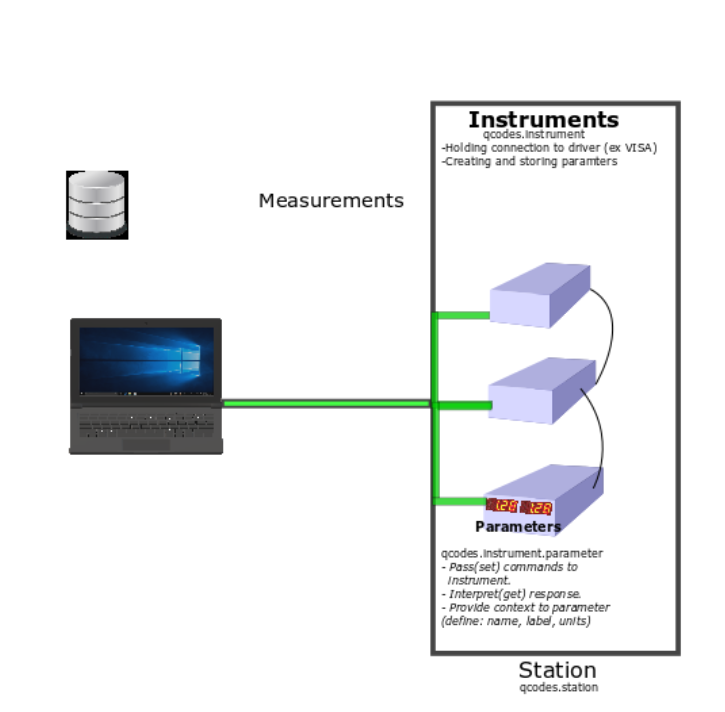


## Imports

Customarily we import as follows:

In [1]:
%matplotlib inline
import os
import numpy.random as rd
import matplotlib.pyplot as plt
from functools import partial
import numpy as np

from time import sleep, monotonic

import qcodes as qc
from qcodes import Station, load_or_create_experiment, \
    initialise_database, Measurement, load_by_run_spec, load_by_guid
from qcodes import load_last_experiment, load_experiment, new_experiment, experiments
from qcodes.tests.instrument_mocks import DummyInstrument
from qcodes.dataset.plotting import plot_dataset
from qcodes.logger.logger import start_all_logging




## Logging 

In [2]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\a-halakh\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Every session must have logging turned on. This not only allows users to have all the logs in case a troubleshooting is required but is also crucial to flush all the logging information to the azure cloud platform(only if you have turned telemetry on in your qcodes configuration). You may look at the location of the 'Filename' shown above to access the log file.

## Station creation  

A station is a collection of all the instruments and devices present in your experiment. It can be thought of as a bucket where you can add your `instruments`, `parameters` and other `components`. Each of these terms have a definite meaning in QCoDeS and is explained in later sections. Once a station is properly configured you can use its instance to access these components. Refer to tutorial on [Station](http://qcodes.github.io/Qcodes/examples/Station.html) for more details.

we start with instantiating instrument class which at the moment does not comprise of any instrument or paramater.

In [3]:
station = qc.Station()

We can look at all the instruments and the parameters inside this station bucket using `snapshot` method. Since at the moment we have not added anything to our station our snapshot will contain nothing. 

### Snapshot

In [4]:
station.snapshot()

{'instruments': {},
 'parameters': {},
 'components': {},
 'default_measurement': []}

The [snapshot](http://qcodes.github.io/Qcodes/examples/DataSet/Working%20with%20snapshots.html) of the station is categorized as the dictionary of all the `instruments`,` parameters`, `components` and list of `default_measurement`. Once you have populated your station you may want to look at the snapshot again.

## Instrument

An instrument represent the hardware you would want to talk to, either to control your system, collect data, or both. Instruments class in Qcodes is reponsible for Holding connections to hardware, creating a parameter, function, or method for each piece of functionality we support. For more details on instrument class you can look at more [detailed description](http://qcodes.github.io/Qcodes/user/intro.html#instrument)  or [api documentation](http://qcodes.github.io/Qcodes/api/instrument/index.html) regarding instruments. 

In [5]:
# A dummy instrument dac with two parameters ch1 and Ch2
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])

# A dummy instrument dmm with two parameters ch1 and Ch2
dmm = DummyInstrument('dmm', gates=['v1', 'v2'])

### Add instruments into station 

In [6]:
station.add_component(dac)
station.add_component(dmm)

'dmm'

### Simulating the response of instrument 

You may **ignore this block** during the first read. In actual experiments you will not need to simulate the response

In [7]:
# a generator to simulate a physical signal, in this case an exponentially
# decaying signal
def exponential_decay(a: float, b: float):
    """
    Yields a*exp(-b*x) where x is put in
    """
    x = 0
    while True:
        x = yield
        yield a*np.exp(-b*x) + 0.02*a*np.random.randn()
        

# and then a bit of "wiring" to make the dmm "measure"
# the exponential decay

ed = exponential_decay(5, 0.2)
next(ed)

def customgetter(dac):
    val = ed.send(dac.ch1())
    next(ed)
    return val

dmm.v1.get = partial(customgetter, dac)

## Parameter

Qcodes `Parameter` has the property that it is settable, gettable or both. Let us understand with the example of a real instrument say oscilloscope. A oscilloscope contains lot of settings such as trigger mode, trigger level, 

An instrument in a particular state can be thought as set of variables, all of which are in a particular state, defining the overall state of the instrument. A parameter represents a single variable from set of all variables used to define the state of the instrument. This variable can be set to some value or its value can be obtained (get) or both. 

In case of a physical instrument, we have to send command(s) to the instrument to define the state of a single variable. A parameter is responsible for generating valid commands to pass to the instrument to set or get a value of this variable. 

In the above case we have 'dac' instrument with 'ch1' and 'ch2' parameters. Similarly, we have dmm instrument with 'v1' and 'v1' as parameters. 

we may set current in 'ch1' as

types of parameters:

In [8]:
dac.ch1(1.1)

and get the ouput voltage of dmm as

In [9]:
dmm.v1()

4.079227845833997

Further information can be found in the [user guide](http://qcodes.github.io/Qcodes/user/intro.html#parameter) or [api documentation](http://qcodes.github.io/Qcodes/api/parameters/index.html) of parameter. 

## Initialise database and experiment

Before starting a measurement we first initialise a database in the location specified by the config object (read the config section below). The db is created with the latest supported version. If the database already exists then that database is used but is upgraded to the latest version.

In [10]:
initialise_database()

### Current location of database

In [11]:
qc.config.core.db_location

'~/experiments.db'

### Change location of database

To change the location of the data base to the current working directory.

In [12]:
cwd = os.getcwd()
qc.config["core"]["db_location"] = os.path.join(cwd, 'testing.db')

### Load or create experiment

After initialising the database we create the `Experiment` object. This object contains the name of the experiment and the sample and the path of the database. You can  use `load_or_create_experiment` to find and return an experiment with the given experiment and sample name if it already exists, or create one if not found.

In [27]:
exp = load_or_create_experiment(experiment_name='dataset_context_manager',
                                sample_name="no sample1")

The methods shown above to load or create the experiment is the most versatile one. However for specifics cases other methods (listed below) to create or load experiments may also be used.

In [14]:
# load_experiment_by_name(experiment_name='dataset_context_manager',sample_name="no sample")
# load_last_experiment()
# load_experiment(1)
# new_experiment(experiment_name='dataset_context_manager',sample_name="no sample")

## Measurement

Qcodes `Measurement` module provides a context manager for registering parameters to measure and store results. The measurement is first linked to the correct experiment and station by passing it as an argument. If no argument is given then the currently loaded experiment and station are taken as default. 

Qcodes is capable of storing relation between parameter i.e. which parameter is independent and which parameter depends on another one. This capability is later used to make useful plots where the knowledge of interdependcies is used to infer what goes on x axis and what on y axis. All the parameters required in the measurement are first registered. In case a parameter depends on another parameter then the another parameter is declared as a 'setpoint'. In qcodes lingo 'setpoint' parameter means the parameter on which another parameter depends. In current example, dac.ch1 is the independent parameter and dmm.v1 is the dependent parameter whose setpoint is dac.ch1.

`meas.write_period` is used to define the  the periods after which the data is committed to the database. We do not commit individual datapoint during measurement to the database but only after some amount of data is collected in stipulated time period (in this case for 2 second).  

**(COnfusion regardign meas.run)**
**datasaver.add_result*** also needs explanation

In [32]:
meas = Measurement(exp=exp, station=station)
meas.register_parameter(dac.ch1)  # register the first independent parameter
meas.register_parameter(dmm.v1, setpoints=(dac.ch1,))  # now register the dependent oone

meas.write_period = 2 

with meas.run() as datasaver:
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        get_v = dmm.v1.get()
        datasaver.add_result((dac.ch1, set_v),
                             (dmm.v1, get_v))

    dataset = datasaver.dataset  # convenient to have for plotting

Starting experimental run with id: 3


## Data exploration

You can list all the experiments in the database as following.

In [29]:
experiments()

[dataset_context_manager#no sample#1@C:\Users\a-halakh\Documents\Microsoft\QcodesHarshit\docs\examples\testing.db
 ----------------------------------------------------------------------------------------------------------------
 1-results-1-dac_ch1,dmm_v1-10,
 dataset_context_manager#no sample1#2@C:\Users\a-halakh\Documents\Microsoft\QcodesHarshit\docs\examples\testing.db
 -----------------------------------------------------------------------------------------------------------------
 2-results-1-dac_ch1,dmm_v1-10]

Currently the database contains only few  experiments but in a lab the database will contain several experiments containing many datasets. Seldom you would like to load a dataset from a particular experiment for further analysis. Here we look at the ways to find and retrieve already measured dataset from the data base.

`load_by_run_spec` can be used to load a run from one or more pieces of runs specification such as 'experiment name', 'sample name' etc. All fields are optional but the function will raise an error if more than one run matching the supplied specification is found. Along with the error specs of the runs found will be printed. Refer to the section 'Uniquely identifying and loading runs' in [this example notbook](http://qcodes.github.io/Qcodes/examples/DataSet/Extracting-runs-from-one-DB-file-to-another.html#Uniquely-identifying-and-loading-runs) 

In [39]:
exp = load_by_run_spec(experiment_name='dataset_context_manager')

  captured_run_id    captured_counter  experiment_name          sample_name      sample_id    location    work_station
-----------------  ------------------  -----------------------  -------------  -----------  ----------  --------------
                1                   1  dataset_context_manager  no sample       2863311530          13              15
                2                   1  dataset_context_manager  no sample1      2863311530          13              15
                3                   2  dataset_context_manager  no sample1      2863311530          13              15


NameError: More than one matching dataset found. Please supply more information to uniquelyidentify a dataset

In [41]:
dataset = load_by_run_spec(experiment_name='dataset_context_manager', captured_run_id=3)

results #3@C:\Users\a-halakh\Documents\Microsoft\QcodesHarshit\docs\examples\testing.db
---------------------------------------------------------------------------------------
dac_ch1 - numeric
dmm_v1 - numeric

Now, you can plot this dataset using `plot_dataset`

([<matplotlib.axes._subplots.AxesSubplot at 0x25ba525d128>], [None])

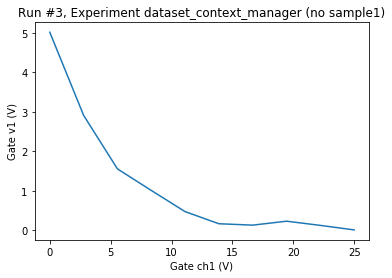

In [43]:
plot_dataset(dataset)

If you are interested in a particular parameter in a dataset you can get is using `get_parameter_data`

In [53]:
dataset.get_parameter_data('dac_ch1')

{'dac_ch1': {'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

In [55]:
dataset.get_parameter_data('dmm_v1')

{'dmm_v1': {'dmm_v1': array([5.01426675, 2.9109591 , 1.5562357 , 1.01084649, 0.47453093,
         0.16767295, 0.13212085, 0.23183596, 0.12604861, 0.01130426]),
  'dac_ch1': array([ 0.        ,  2.77777778,  5.55555556,  8.33333333, 11.11111111,
         13.88888889, 16.66666667, 19.44444444, 22.22222222, 25.        ])}}

Refer to exporting data section of the [example notebook](http://qcodes.github.io/Qcodes/examples/DataSet/Dataset%20Context%20Manager.html?highlight=get_parameter_data) to have more information on `get_parameter_data`

You can look at the datasets in the current experiment using:

In [42]:
exp.data_sets()

AttributeError: 'DataSet' object has no attribute 'data_sets'

Now you can plot the datasets

In [31]:

exp.data_set() to look at the datasets




DataSet.get_parameter_data()
get_functions_as_pandas_dataframe


Measurement
station and experiment is explicity passed

SyntaxError: invalid syntax (<ipython-input-31-a93ccddce676>, line 1)

## Other important things

### QCoDeS Configuration  

The default config file should not be overwritten, so if you have any modifications, you should save the updated config file on your home directory OR in the current working directory of your script/notebook. The QCoDeS config system first looks in the current directory for a config file and then in the home directory for one and only then - if no config files where found - does it fall back to using the default one. The default config is located in `qcodes.qcodes.config`

In [ ]:
station.snapshot()

### Working with pandas

In [ ]:
exp = load_or_create_experiment(experiment_name='dataset_context_manager',
                          sample_name="sample2")

In [ ]:
experiments()

## Monitor

## Drivers